In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. THE "PLANT" (Simulation Environment)
# ==========================================

In [ ]:
class SmartHomeEnv:
    def __init__(self, battery_capacity=10.0, max_power=5.0, seed=42):
        self.battery_capacity = battery_capacity # kWh
        self.max_power = max_power # kW
        self.soc = 0.0 # Initial State of Charge (kWh)
        self.time_step = 0

        # Set a fixed seed for reproducibility
        np.random.seed(seed)

        # Internal Data Generation (The "Real World")
        self.data = self._generate_scenario_data(hours=72)

    def _generate_scenario_data(self, hours):
        t = np.arange(hours)
        # Solar: Peak at noon + random clouds
        solar = np.maximum(0, 5 * np.sin(2 * np.pi * (t - 6) / 24))
        solar = solar - np.random.uniform(0.8, 1.0, size=hours)

        # Load: Morning/Evening peaks
        load = 2 + 1.5 * np.sin(2 * np.pi * (t - 8) / 24) + \
               1.5 * np.sin(2 * np.pi * (t - 18) / 24)
        load = np.maximum(0.5, load)

        # Price: High in evening
        price = 0.20 + 0.10 * np.sin(2 * np.pi * (t - 18) / 24)

        return pd.DataFrame({'solar': solar, 'load': load, 'price': price})

    def reset(self):
        self.soc = 0.0
        self.time_step = 0
        return self.data.iloc[0]

    def step(self, action_kw):
        """
        Executes one time step.
        Args:
            action_kw (float): Desired battery power (+ Charge, - Discharge)
        Returns:
            observation (Series): The NEXT state (load, solar, price)
            reward (float): The cost incurred this step
            done (bool): Is simulation over?
            info (dict): Debug info
        """
        current_data = self.data.iloc[self.time_step]

        # --- 1. Apply Physics Constraints (The "Real" Battery) ---
        # A. Power Limits
        power = np.clip(action_kw, -self.max_power, self.max_power)

        # B. Capacity Limits
        if power > 0: # Charging
            max_charge = self.battery_capacity - self.soc
            power = min(power, max_charge)
        else: # Discharging
            max_discharge = self.soc
            power = max(power, -max_discharge) # (power is negative)

        # --- 2. Update State ---
        self.soc += power # Simple energy bucket model (1 hour timestep)

        # --- 3. Calculate Cost ---
        # Grid Balance: Load + Charge = Solar + Discharge + Grid
        # Grid = (Load - Solar) + Power
        net_load = current_data['load'] - current_data['solar']
        grid_kw = net_load + power

        cost = grid_kw * current_data['price']

        # --- 4. Prepare Next Step ---
        self.time_step += 1
        done = self.time_step >= len(self.data)

        next_obs = None
        if not done:
            next_obs = self.data.iloc[self.time_step]

        info = {
            'soc': self.soc,
            'grid_kw': grid_kw,
            'battery_action_actual': power,
            'load': current_data['load'],
            'solar': current_data['solar'],
            'price': current_data['price']
        }

        return next_obs, cost, done, info

    def get_forecast(self, horizon=24):
        """Returns the data for the next N hours (for MPC)"""
        start = self.time_step
        end = min(start + horizon, len(self.data))
        return self.data.iloc[start:end]

# ==========================================
# 2. THE CONTROLLERS
# ==========================================

In [ ]:
class Controller:
    def __init__(self, env):
        self.bat_cap = env.battery_capacity
        self.max_p = env.max_power

    def get_action(self, observation):
        raise NotImplementedError

In [ ]:
class RuleBasedController(Controller):

    def get_action(self, observation, current_soc):
        """
        The Logic: Store excess solar, discharge for any deficit.
        """
        net_load = observation['load'] - observation['solar']

        if net_load < 0:
            # Surplus -> Charge
            # We ask for max possible, Environment handles the limits
            return self.max_p
        else:
            # Deficit -> Discharge
            # We ask for max discharge, Environment handles the limits
            return -self.max_p

In [ ]:
class CostOptimizedRuleBasedController(Controller):
    def __init__(self, env, price_threshold=0.25):
        super().__init__(env)

        self.price_threshold = price_threshold # Threshold to define 'high' vs 'low' price

    def get_action(self, observation, current_soc):
        net_load = observation['load'] - observation['solar']
        current_price = observation['price']

        if net_load < 0: # Solar surplus
            # Always try to charge the battery with excess solar (it's free!)
            return self.max_p # Request maximum charge

        else: # net_load >= 0 (Demand exceeds solar or no solar)
            if current_price > self.price_threshold: # Price is high
                # Try to discharge the battery to meet demand and avoid buying expensive grid energy
                return -self.max_p # Request maximum discharge
            else: # Price is low or moderate
                # Avoid discharging the battery (buy from grid if needed) or hold charge
                # Returning 0.0 means no battery action, grid will cover the net_load.
                # If the battery is very low and price is exceptionally low, one might consider charging from grid,
                # but for simplicity in this rule-based controller, we prioritize discharging at high prices.
                return 0.0

In [ ]:
class SOCAwareRuleBasedController(Controller):
    def __init__(self, env, price_threshold=0.25):
        super().__init__(env)
        self.price_threshold = price_threshold

    def get_action(self, observation, current_soc):
        net_load = observation['load'] - observation['solar']
        current_price = observation['price']

        # Define small buffer for capacity limits to avoid constant charging/discharging at limits
        charge_buffer = self.max_p * 0.1 # Example: keep 10% of max_power capacity free
        discharge_buffer = self.max_p * 0.1 # Example: don't discharge past 10% of max_power

        if net_load < 0:  # Solar surplus
            # If there's capacity, charge
            if current_soc < self.bat_cap - charge_buffer:
                return self.max_p  # Request maximum charge
            else:
                return 0.0  # Battery is full or nearly full, no action
        else:  # net_load >= 0 (Demand exceeds solar or no solar)
            if current_price > self.price_threshold:  # Price is high
                # If there's energy in the battery, discharge
                if current_soc > discharge_buffer: # Ensure we don't try to discharge an empty battery
                    return -self.max_p  # Request maximum discharge
                else:
                    return 0.0  # Battery is empty or nearly empty, no action
            else:  # Price is low or moderate
                # No action: either buy from grid or hold charge for higher prices
                return 0.0


In [ ]:
class PVOptimalController(Controller):
    def __init__(self, env, min_soc_percent=0.1, safety_buffer_percent=0.1):
        super().__init__(env)
        # Minimum SoC before grid backup or optional grid charge
        self.min_soc_kwh = self.bat_cap * min_soc_percent
        # Target SoC to maintain via optional grid charging
        self.safety_buffer_kwh = self.bat_cap * safety_buffer_percent

    def get_action(self, observation, current_soc):
        net_load = observation['load'] - observation['solar']
        action = 0.0 # Default: no battery action (grid takes over)

        if net_load < 0: # Rule 1: Solar surplus (PV generation > House Load)
            # Direct PV energy to House Load (handled by net_load calculation already)
            # Direct excess PV to Battery Charging (request max charge)
            # If Battery is full, export excess to Grid (environment handles clipping)
            action = self.max_p
        else: # PV generation < House Load (or equal) / Demand exceeds solar
            if current_soc > self.min_soc_kwh: # Rule 2: Battery has energy above minimum
                # Discharge Battery to cover the deficit (request max discharge)
                action = -self.max_p
            else: # Rule 3: Battery SoC <= Minimum Limit
                # Draw power from Grid to cover House Load (default action is 0.0)
                # Optional: charge Battery from Grid to maintain "Safety Buffer"
                if current_soc < self.safety_buffer_kwh:
                    # Calculate how much charge is needed to reach the safety buffer
                    charge_needed = self.safety_buffer_kwh - current_soc
                    # Request to charge, capped by max_power. This is grid charging.
                    action = min(self.max_p, charge_needed)
                # If current_soc is between safety_buffer_kwh and min_soc_kwh, action remains 0.0
                # If current_soc is already at or above safety_buffer_kwh, action remains 0.0

        return action

In [ ]:
class RandomController(Controller):
    def get_action(self, observation, _):
        return np.random.uniform(-self.max_p, self.max_p)

# ==========================================
# 3. MAIN LOOP (The "Gym" Loop)
# ==========================================

In [ ]:
def run_experiment(Controller):
    # Setup
    env = SmartHomeEnv()
    agent = Controller(env)
   # agent = CostOptimizedRuleBasedController(env)
   # agent = SOCAwareRuleBasedController(env)
    # History Storage
    results = []

    # Start
    obs = env.reset()
    done = False

    print("Starting Simulation...")

    while not done:
        # 1. Agent decides
        # Note: RuleBased needs current SOC to be perfect, but here we
        # just ask for MAX and let physics clip it.
        action_requested = agent.get_action(obs, env.soc)

        # 2. Environment reacts
        next_obs, cost, done, info = env.step(action_requested)

        # 3. Store Data
        info['action_requested'] = action_requested # Log the requested action
        results.append(info)

        # 4. Advance
        obs = next_obs

    # Process Results
    df_res = pd.DataFrame(results)
    return df_res

# ==========================================
# 4. VISUALIZATION
# ==========================================

In [ ]:
def plot_controller_performance(df, controller_name, total_cost):
    print(f"Total Cost for {controller_name}: €{total_cost:.2f}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Ax1: Physics
    ax1.set_title(f"{controller_name}: Power Flows")
    ax1.plot(df['load'], 'k--', label='Load', alpha=0.5)
    ax1.plot(df['solar'], 'orange', label='Solar', alpha=0.5)
    ax1.bar(df.index, df['battery_action_actual'], color='green', alpha=0.3, label='Battery Flow')
    ax1.legend()
    ax1.set_ylabel("kW")

    # Ax2: Battery State
    ax2.set_title(f"{controller_name}: Battery State of Charge")
    ax2.plot(df['soc'], 'g-', linewidth=2)
    ax2.set_ylabel("kWh")
    ax2.set_xlabel("Hour")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========================================
# 5. COMPARISON
# ==========================================

Starting Simulation...
Starting Simulation...
Starting Simulation...
Starting Simulation...
Starting Simulation...


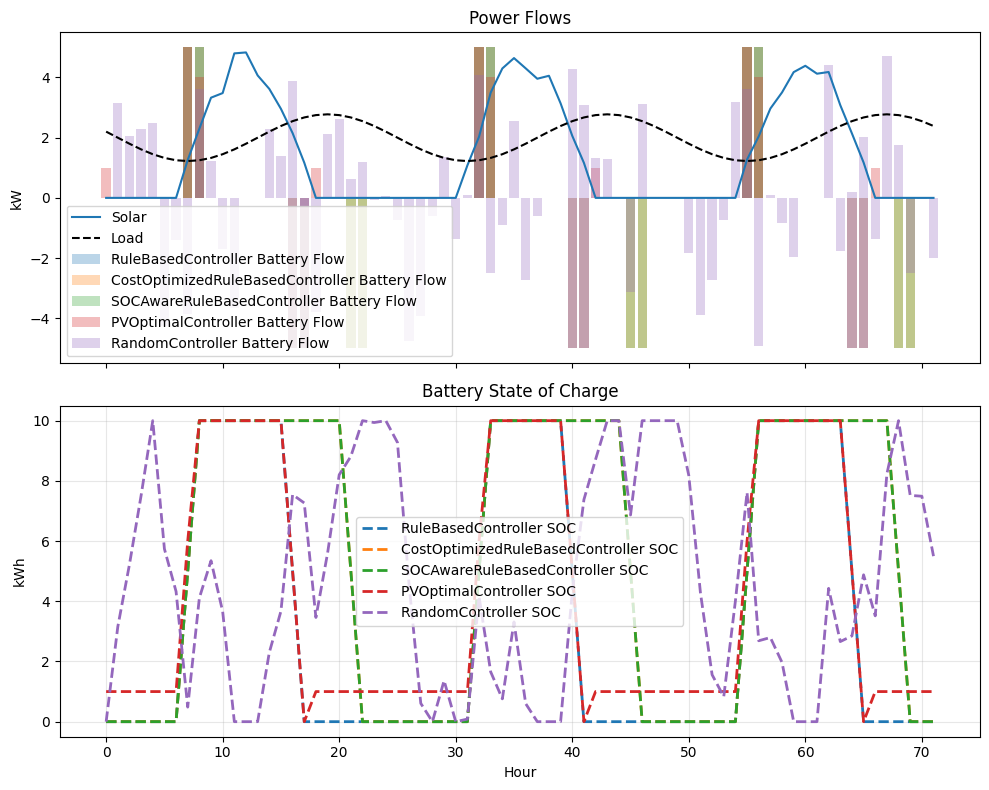

In [ ]:
controllers = {
    "RuleBasedController": RuleBasedController,
    "CostOptimizedRuleBasedController": CostOptimizedRuleBasedController,
    "SOCAwareRuleBasedController": SOCAwareRuleBasedController,
    "PVOptimalController": PVOptimalController,
    "RandomController": RandomController
}

all_results = {}
for name, controller in controllers.items():
    all_results[name] = run_experiment(controller)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
df = all_results['RuleBasedController']
ax1.plot(df['solar'], label='Solar')
ax1.plot(df['load'], 'k--', label='Load')
for name, df in all_results.items():
   # total_cost = df['cost'].sum()
    #print(f"Total Cost for {name}: €{total_cost:.2f}")


    # Ax1: Physics
    ax1.set_title("Power Flows")


    ax1.bar(df.index, df['battery_action_actual'], alpha=0.3, label=f'{name} Battery Flow')
    ax1.legend()
    ax1.set_ylabel("kW")

    # Ax2: Battery State
    ax2.set_title("Battery State of Charge")
    ax2.plot(df['soc'], '--', linewidth=2, label=f"{name} SOC")
    ax2.set_ylabel("kWh")
    ax2.set_xlabel("Hour")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
plt.show()